In [63]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


In [18]:
# !pip3 install numpy==1.23.5


## Tools

In [20]:
"""

This module contains wrappers and convenience functions to simplify
working with gym environments of different kinds.

"""
from typing import Callable

from IPython import display
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns
import gym
import torch
import numpy as np


def plot_policy(probs_or_qvals, frame, action_meanings=None):
    if action_meanings is None:
        action_meanings = {0: 'U', 1: 'R', 2: 'D', 3: 'L'}
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    max_prob_actions = probs_or_qvals.argmax(axis=-1)
    probs_copy = max_prob_actions.copy().astype(np.object)
    for key in action_meanings:
        probs_copy[probs_copy == key] = action_meanings[key]
    sns.heatmap(max_prob_actions, annot=probs_copy, fmt='', cbar=False, cmap='coolwarm',
                annot_kws={'weight': 'bold', 'size': 12}, linewidths=2, ax=axes[0])
    axes[1].imshow(frame)
    axes[0].axis('off')
    axes[1].axis('off')
    plt.suptitle("Policy", size=24)
    plt.tight_layout()


def plot_values(state_values, frame):
    f, axes = plt.subplots(1, 2, figsize=(12, 5))
    sns.heatmap(state_values, annot=True, fmt=".2f", cmap='coolwarm',
                annot_kws={'weight': 'bold', 'size': 12}, linewidths=2, ax=axes[0])
    axes[1].imshow(frame)
    axes[0].axis('off')
    axes[1].axis('off')
    plt.tight_layout()


def plot_action_values(action_values):

    text_positions = [
        [(0.35, 4.75), (1.35, 4.75), (2.35, 4.75), (3.35, 4.75), (4.35, 4.75),
         (0.35, 3.75), (1.35, 3.75), (2.35, 3.75), (3.35, 3.75), (4.35, 3.75),
         (0.35, 2.75), (1.35, 2.75), (2.35, 2.75), (3.35, 2.75), (4.35, 2.75),
         (0.35, 1.75), (1.35, 1.75), (2.35, 1.75), (3.35, 1.75), (4.35, 1.75),
         (0.35, 0.75), (1.35, 0.75), (2.35, 0.75), (3.35, 0.75), (4.35, 0.75)],
        [(0.6, 4.45), (1.6, 4.45), (2.6, 4.45), (3.6, 4.45), (4.6, 4.45),
         (0.6, 3.45), (1.6, 3.45), (2.6, 3.45), (3.6, 3.45), (4.6, 3.45),
         (0.6, 2.45), (1.6, 2.45), (2.6, 2.45), (3.6, 2.45), (4.6, 2.45),
         (0.6, 1.45), (1.6, 1.45), (2.6, 1.45), (3.6, 1.45), (4.6, 1.45),
         (0.6, 0.45), (1.6, 0.45), (2.6, 0.45), (3.6, 0.45), (4.6, 0.45)],
        [(0.35, 4.15), (1.35, 4.15), (2.35, 4.15), (3.35, 4.15), (4.35, 4.15),
         (0.35, 3.15), (1.35, 3.15), (2.35, 3.15), (3.35, 3.15), (4.35, 3.15),
         (0.35, 2.15), (1.35, 2.15), (2.35, 2.15), (3.35, 2.15), (4.35, 2.15),
         (0.35, 1.15), (1.35, 1.15), (2.35, 1.15), (3.35, 1.15), (4.35, 1.15),
         (0.35, 0.15), (1.35, 0.15), (2.35, 0.15), (3.35, 0.15), (4.35, 0.15)],
        [(0.05, 4.45), (1.05, 4.45), (2.05, 4.45), (3.05, 4.45), (4.05, 4.45),
         (0.05, 3.45), (1.05, 3.45), (2.05, 3.45), (3.05, 3.45), (4.05, 3.45),
         (0.05, 2.45), (1.05, 2.45), (2.05, 2.45), (3.05, 2.45), (4.05, 2.45),
         (0.05, 1.45), (1.05, 1.45), (2.05, 1.45), (3.05, 1.45), (4.05, 1.45),
         (0.05, 0.45), (1.05, 0.45), (2.05, 0.45), (3.05, 0.45), (4.05, 0.45)]]

    fig, ax = plt.subplots(figsize=(9, 9))
    tripcolor = quatromatrix(action_values, ax=ax,
                             triplotkw={"color": "k", "lw": 1}, tripcolorkw={"cmap": "coolwarm"})
    ax.margins(0)
    ax.set_aspect("equal")
    fig.colorbar(tripcolor)

    for j, av in enumerate(text_positions):
        for i, (xi, yi) in enumerate(av):
            plt.text(xi, yi, round(action_values[:, :, j].flatten()[i], 2), size=10, color="w", weight="bold")

    plt.title("Action values Q(s,a)", size=18)
    plt.tight_layout()
    plt.show()


def quatromatrix(action_values, ax=None, triplotkw=None, tripcolorkw=None):
    action_values = np.flipud(action_values)
    n = 5
    m = 5
    a = np.array([[0, 0], [0, 1], [.5, .5], [1, 0], [1, 1]])
    tr = np.array([[0, 1, 2], [0, 2, 3], [2, 3, 4], [1, 2, 4]])
    A = np.zeros((n * m * 5, 2))
    Tr = np.zeros((n * m * 4, 3))
    for i in range(n):
        for j in range(m):
            k = i * m + j
            A[k * 5:(k + 1) * 5, :] = np.c_[a[:, 0] + j, a[:, 1] + i]
            Tr[k * 4:(k + 1) * 4, :] = tr + k * 5
    C = np.c_[action_values[:, :, 3].flatten(), action_values[:, :, 2].flatten(),
              action_values[:, :, 1].flatten(), action_values[:, :, 0].flatten()].flatten()

    ax.triplot(A[:, 0], A[:, 1], Tr, **triplotkw)
    tripcolor = ax.tripcolor(A[:, 0], A[:, 1], Tr, facecolors=C, **tripcolorkw)
    return tripcolor


def test_agent(env: gym.Env, policy: Callable, episodes: int = 10) -> None:
    plt.figure(figsize=(8, 8))
    for episode in range(episodes):
        state = env.reset()
        done = False
        img = plt.imshow(env.render(mode='rgb_array'))
        while not done:
            p = policy(state)
            if isinstance(p, np.ndarray):
                action = np.random.choice(4, p=p)
            else:
                action = p
            next_state, _, done, _ = env.step(action)
            img.set_data(env.render(mode='rgb_array'))
            plt.axis('off')
            display.display(plt.gcf())
            display.clear_output(wait=True)
            state = next_state


def plot_cost_to_go(env, q_network, xlabel=None, ylabel=None):
    highx, highy = env.observation_space.high
    lowx, lowy = env.observation_space.low
    X = torch.linspace(lowx, highx, 100)
    Y = torch.linspace(lowy, highy, 100)
    X, Y = torch.meshgrid(X, Y)

    q_net_input = torch.stack([X.flatten(), Y.flatten()], dim=-1)
    Z = - q_network(q_net_input).max(dim=-1, keepdim=True)[0]
    Z = Z.reshape(100, 100).detach().numpy()
    X = X.numpy()
    Y = Y.numpy()

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X, Y, Z, cmap='jet', linewidth=0, antialiased=False)
    fig.colorbar(surf, shrink=0.5, aspect=5)
    ax.set_xlabel(xlabel, size=14)
    ax.set_ylabel(ylabel, size=14)
    ax.set_title("Estimated cost-to-go", size=18)
    plt.tight_layout()
    plt.show()


def plot_tabular_cost_to_go(action_values, xlabel, ylabel):
    plt.figure(figsize=(8, 8))
    cost_to_go = -action_values.max(axis=-1)
    plt.imshow(cost_to_go, cmap='jet')
    plt.title("Estimated cost-to-go", size=24)
    plt.xlabel(xlabel, size=18)
    plt.ylabel(ylabel, size=18)
    plt.xticks([])
    plt.yticks([])
    plt.xticks()
    plt.colorbar()
    plt.tight_layout()
    plt.show()


def plot_max_q(env, q_network, xlabel=None, ylabel=None, action_labels=[]):
    highx, highy = env.observation_space.high
    lowx, lowy = env.observation_space.low
    X = torch.linspace(lowx, highx, 100)
    Y = torch.linspace(lowy, highy, 100)
    X, Y = torch.meshgrid(X, Y)
    q_net_input = torch.stack([X.flatten(), Y.flatten()], dim=-1)
    Z = q_network(q_net_input).argmax(dim=-1, keepdim=True)
    Z = Z.reshape(100, 100).T.detach().numpy()
    values = np.unique(Z.ravel())
    values.sort()

    plt.figure(figsize=(5, 5))
    plt.xlabel(xlabel, size=14)
    plt.ylabel(ylabel, size=14)
    plt.title("Optimal action", size=18)

    # im = plt.imshow(Z, interpolation='none', cmap='jet')
    im = plt.imshow(Z, cmap='jet')
    colors = [im.cmap(im.norm(value)) for value in values]
    patches = [mpatches.Patch(color=color, label=label) for color, label in zip(colors, action_labels)]
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.tight_layout()


def plot_stats(stats):
    rows = len(stats)
    cols = 1

    fig, ax = plt.subplots(rows, cols, figsize=(12, 6))

    for i, key in enumerate(stats):
        vals = stats[key]
        vals = [np.mean(vals[i-10:i+10]) for i in range(10, len(vals)-10)]
        if len(stats) > 1:
            ax[i].plot(range(len(vals)), vals)
            ax[i].set_title(key, size=18)
        else:
            ax.plot(range(len(vals)), vals)
            ax.set_title(key, size=18)
    plt.tight_layout()
    plt.show()


def seed_everything(env: gym.Env, seed: int = 42) -> None:
    """
    Seeds all the sources of randomness so that experiments are reproducible.
    Args:
        env: the environment to be seeded.
        seed: an integer seed.
    Returns:
        None.
    """
    env.seed(seed)
    env.action_space.seed(seed)
    env.observation_space.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.set_deterministic(True)


def test_policy_network(env, policy, episodes=1):
    from IPython import display
    plt.figure(figsize=(6, 6))
    for episode in range(episodes):
        state = env.reset()
        done = False
        img = plt.imshow(env.render(mode='rgb_array'))
        while not done:
            state = torch.from_numpy(state).unsqueeze(0).float()
            action = policy(state).multinomial(1).item()
            next_state, _, done, _ = env.step(action)
            img.set_data(env.render(mode='rgb_array'))
            plt.axis('off')
            display.display(plt.gcf())
            display.clear_output(wait=True)
            state = next_state


def plot_action_probs(probs, labels):
    plt.figure(figsize=(6, 4))
    plt.bar(labels, probs, color ='orange')
    plt.title("$\pi(s)$", size=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()

In [21]:
"""
Maze environment used in the first three modules of the course:
"Beginner to Master: Reinforcement Learning".
"""


from typing import Tuple, Dict, Optional, Iterable

import numpy as np

import gym
from gym import spaces
from gym.error import DependencyNotInstalled

import pygame
from pygame import gfxdraw


class Maze(gym.Env):
    """
    Description:
        The environment consists of a grid of (size x size) positions. The agent
        starts the episode in location (row=0, col=0) if the environment is instantiated
        without exploring starts or from a random location (different from the goal)
         if it is. The goal is always at (row=size-1, col=size-1).
    Observation:
        Type: MultiDiscrete(2)
        Num     Observation     Min     Max
        0       row coordinate    0       size-1
        1       col coordinate    0       size-1
    Actions:
        Type: Discrete(4)
        Num     Action
        0       Move up
        1       Move right
        2       Move down
        3       Move left
    Reward:
        If the environment is instantiated with shaped rewards, then at each time step
        the agent will receive a reward signal of the following magnitude:

            r = - steps_to_goal(current_state) / steps_to_goal(furthest_state)

        This ensures that the maximum reward awarded will be -1.0 and that at the goal
        the reward will be 0.

        If the environment is instantiated without shaped rewards, then at each time step
        the agent will receive a reward of -1.0 until it reaches the goal.
    Episode termination:
        The episode terminates when the agent reaches the goal state.
    """

    def __init__(self, exploring_starts: bool = False,
                 shaped_rewards: bool = False, size: int = 5) -> None:
        """
        Initialize the environment.

        Args:
            exploring_starts: should the agent restart at a random location or not.
            shaped_rewards: should the environment shape the rewards.
            size: size of the maze. Will be of shape (size x size).
        """
        super().__init__()
        self.exploring_starts = exploring_starts
        self.shaped_rewards = shaped_rewards
        self.state = (size - 1, size - 1)
        self.goal = (size - 1, size - 1)
        self.maze = self._create_maze(size=size)
        self.distances = self._compute_distances(self.goal, self.maze)
        self.action_space = spaces.Discrete(n=4)
        self.action_space.action_meanings = {0: 'UP', 1: 'RIGHT', 2: 'DOWN', 3: "LEFT"}
        self.observation_space = spaces.MultiDiscrete([size, size])

        self.screen = None
        self.agent_transform = None

    def step(self, action: int) -> Tuple[Tuple[int, int], float, bool, Dict]:
        """
        Take an action in the environment and observe the next transition.

        Args:
            action: An indicator of the action to be taken.

        Returns:
            The next transition.
        """
        reward = self.compute_reward(self.state, action)
        self.state = self._get_next_state(self.state, action)
        done = self.state == self.goal
        info = {}
        return self.state, reward, done, info

    def reset(self) -> Tuple[int, int]:
        """
        Reset the environment to execute a new episode.

        Returns: State representing the initial position of the agent.
        """
        if self.exploring_starts:
            while self.state == self.goal:
                self.state = tuple(self.observation_space.sample())
        else:
            self.state = (0, 0)
        return self.state

    def render(self, mode: str = 'human') -> Optional[np.ndarray]:
        """
        Render a state of the environment.

        Args:
            mode: one of 'human' or 'rgb_array'. Human added only for compatibility.
            All rendering will be done in 'rgb arrays' via NumPy.

        Returns:
            A numpy.ndarray or None.

        """
        assert mode in ['human', 'rgb_array']

        screen_size = 600
        scale = screen_size / 5

        if self.screen is None:
            pygame.init()
            self.screen = pygame.Surface((screen_size, screen_size))

        surf = pygame.Surface((screen_size, screen_size))
        surf.fill((22, 36, 71))


        for row in range(5):
            for col in range(5):

                state = (row, col)
                for next_state in [(row + 1, col), (row - 1, col), (row, col + 1), (row, col - 1)]:
                    if next_state not in self.maze[state]:

                        # Add the geometry of the edges and walls (i.e. the boundaries between
                        # adjacent squares that are not connected).
                        row_diff, col_diff = np.subtract(next_state, state)
                        left = (col + (col_diff > 0)) * scale - 2 * (col_diff != 0)
                        right = ((col + 1) - (col_diff < 0)) * scale + 2 * (col_diff != 0)
                        top = (5 - (row + (row_diff > 0))) * scale - 2 * (row_diff != 0)
                        bottom = (5 - ((row + 1) - (row_diff < 0))) * scale + 2 * (row_diff != 0)

                        gfxdraw.filled_polygon(surf, [(left, bottom), (left, top), (right, top), (right, bottom)], (255, 255, 255))

        # Add the geometry of the goal square to the viewer.
        left, right, top, bottom = scale * 4 + 10, scale * 5 - 10, scale - 10, 10
        gfxdraw.filled_polygon(surf, [(left, bottom), (left, top), (right, top), (right, bottom)], (40, 199, 172))

        # Add the geometry of the agent to the viewer.
        agent_row = int(screen_size - scale * (self.state[0] + .5))
        agent_col = int(scale * (self.state[1] + .5))
        gfxdraw.filled_circle(surf, agent_col, agent_row, int(scale * .6 / 2), (228, 63, 90))

        surf = pygame.transform.flip(surf, False, True)
        self.screen.blit(surf, (0, 0))

        return np.transpose(
                np.array(pygame.surfarray.pixels3d(self.screen)), axes=(1, 0, 2)
            )

    def close(self) -> None:
        """
        Clean up resources before shutting down the environment.

        Returns: None.
        """
        if self.screen is not None:
            pygame.display.quit()
            pygame.quit()
            self.screen = None

    def compute_reward(self, state: Tuple[int, int], action: int) -> float:
        """
        Compute the reward attained by taking action 'a' at state 's'.

        Args:
            state: the state of the agent prior to taking the action.
            action: the action taken by the agent.

        Returns:
            A float representing the reward signal received by the agent.

        """
        next_state = self._get_next_state(state, action)
        if self.shaped_rewards:
            return - (self.distances[next_state] / self.distances.max())
        return - float(state != self.goal)

    def simulate_step(self, state: Tuple[int, int], action: int):
        """

        Simulate (without taking) a step in the environment.

        Args:
            state: the state of the agent prior to taking the action.
            action: the action to simulate the step with.

        Returns:
            The next transition.

        """
        reward = self.compute_reward(state, action)
        next_state = self._get_next_state(state, action)
        done = next_state == self.goal
        info = {}
        return next_state, reward, done, info

    def _get_next_state(self, state: Tuple[int, int], action: int) -> Tuple[int, int]:
        """
        Gets the next state after the agent performs action 'a' in state 's'. If there is a
        wall in the way, the next state will be the same as the current.

        Args:
            state: current state (before taking the action).
            action: move performed by the agent.

        Returns: a State instance representing the new state.
        """
        if action == 0:
            next_state = (state[0] - 1, state[1])
        elif action == 1:
            next_state = (state[0], state[1] + 1)
        elif action == 2:
            next_state = (state[0] + 1, state[1])
        elif action == 3:
            next_state = (state[0], state[1] - 1)
        else:
            raise ValueError("Action value not supported:", action)
        if next_state in self.maze[state]:
            return next_state
        return state

    @staticmethod
    def _create_maze(size: int) -> Dict[Tuple[int, int], Iterable[Tuple[int, int]]]:
        """
        Creates a representation of the maze as a dictionary where the keys are
        the states available to the agent and the values are lists of adjacent
        states.

        Args:
            size: number of elements of each side in the square grid.

        Returns: the adjacency list dictionary.
        """

        maze = {(row, col): [(row - 1, col), (row + 1, col), (row, col - 1), (row, col + 1)]
                for row in range(size) for col in range(size)}

        left_edges = [[(row, 0), (row, -1)] for row in range(size)]
        right_edges = [[(row, size - 1), (row, size)] for row in range(size)]
        upper_edges = [[(0, col), (-1, col)] for col in range(size)]
        lower_edges = [[(size - 1, col), (size, col)] for col in range(size)]
        walls = [
            [(1, 0), (1, 1)], [(2, 0), (2, 1)], [(3, 0), (3, 1)],
            [(1, 1), (1, 2)], [(2, 1), (2, 2)], [(3, 1), (3, 2)],
            [(3, 1), (4, 1)], [(0, 2), (1, 2)], [(1, 2), (1, 3)],
            [(2, 2), (3, 2)], [(2, 3), (3, 3)], [(2, 4), (3, 4)],
            [(4, 2), (4, 3)], [(1, 3), (1, 4)], [(2, 3), (2, 4)],
        ]

        obstacles = upper_edges + lower_edges + left_edges + right_edges + walls

        for src, dst in obstacles:
            maze[src].remove(dst)

            if dst in maze:
                maze[dst].remove(src)

        return maze

    @staticmethod
    def _compute_distances(goal: Tuple[int, int],
                           maze: Dict[Tuple[int, int], Iterable[Tuple[int, int]]]) -> np.ndarray:
        """
        Compute the distance to the goal from all other positions in the maze using Dijkstra's
        algorithm.

        Args:
            goal: A tuple representing the location of the goal in a two-dimensional grid.
            maze: A dictionary holding the adjacency lists of all locations in the
            two-dimensional grid.

        Returns: A (H x W) numpy array holding the minimum number of moves for each position
        to reach the goal.

        """
        distances = np.full((5, 5), np.inf)
        visited = set()
        distances[goal] = 0.

        while visited != set(maze):
            sorted_dst = [(v // 5, v % 5) for v in distances.argsort(axis=None)]
            closest = next(x for x in sorted_dst if x not in visited)
            visited.add(closest)

            for neighbour in maze[closest]:
                distances[neighbour] = min(distances[neighbour], distances[closest] + 1)
        return distances


## Algo

In [301]:
env = Maze()

In [302]:
initial_state = env.reset()
print(f"The new episode will start in state: {initial_state}")

The new episode will start in state: (0, 0)


## 0 -> Up
## 1 -> Right
## 2 -> Down
## 3 -> Left

In [303]:
action = 1
next_state, reward, done, info = env.step(action)
print(f"After moving down 1 row, the agent is in state: {next_state}")
print(f"After moving down 1 row, we got a reward of: {reward}")
print("After moving down 1 row, the task is", "" if done else "not", "finished")

After moving down 1 row, the agent is in state: (0, 1)
After moving down 1 row, we got a reward of: -1.0
After moving down 1 row, the task is not finished


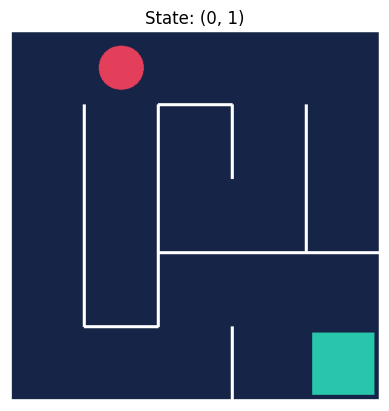

In [304]:
frame = env.render(mode='rgb_array')
plt.axis('off')
plt.title(f"State: {next_state}")
plt.imshow(frame)

In [305]:
print(f"Observation space shape: {env.observation_space.nvec}")
print(f"Number of actions: {env.action_space.n}")

Observation space shape: [5 5]
Number of actions: 4


In [306]:
action_values = np.full((5,5,4), -1000)
action_values[4,4,:] = 0.

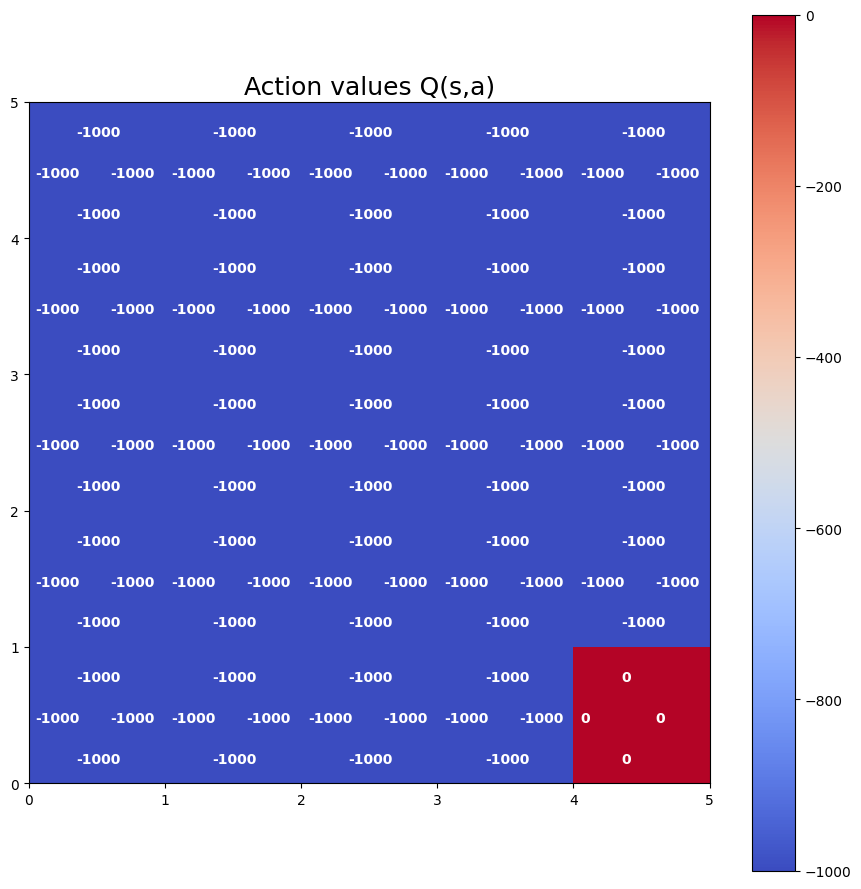

In [307]:
plot_action_values(action_values)

In [308]:
def target_policy(state):
    av = action_values[state]
    return np.random.choice(np.flatnonzero(av == av.max()))

In [309]:
action = target_policy((0,0))
print(f"Action taken in state (0,0): {action}")

Action taken in state (0,0): 0


In [310]:
def exploratory_policy(state, epsilon=0.):
    if np.random.random() < epsilon:
        return np.random.randint(4)
    else:
        av = action_values[state]
        return np.random.choice(np.flatnonzero(av == av.max())) 

In [311]:
action = exploratory_policy((0,0))
print(f"Action taken in state (0,0): {action}")

Action taken in state (0,0): 2


In [312]:
def off_policy_mc_control(action_values, target_policy, exploratory_policy, episodes, gamma=0.99, epsilon=0.5):
    t = None
    for n in tqdm(range(1,episodes+1), desc="Episodes..."):
        G = 0
        W = 1
        csa = np.zeros((5, 5, 4))
        state = env.reset()
        done = False
        transitions = []
        
        while not done:
            action = exploratory_policy(state, epsilon)
            next_state, reward, done, _ = env.step(action)
            transitions.append([state, action, reward])
            state = next_state

        for state_t, action_t, reward_t in reversed(transitions):
            G = reward_t + (gamma * G)
            csa[state_t][action_t] += W
            qsa = action_values[state_t][action_t]
            action_values[state_t][action_t] += (W / csa[state_t][action_t]) * (G - qsa)

            if action_t != target_policy(state_t):
                print(state_t, action_t, action_values[state_t][action_t])
                break
        
            W = W * 1. / (1 - epsilon + epsilon/4)



In [313]:
off_policy_mc_control(action_values, target_policy, exploratory_policy, episodes=100, epsilon=0.3)

Episodes...:  15%|████▎                        | 15/100 [00:00<00:01, 45.61it/s]

(4, 3) 2 -1
(4, 3) 1 -1
(4, 3) 1 -1
(3, 4) 0 -1
(3, 2) 0 -3
(3, 4) 0 -2
(3, 2) 1 -3
(3, 4) 2 -1
(3, 4) 2 -1
(3, 2) 1 -3
(3, 2) 0 -3
(4, 2) 2 -4
(4, 3) 2 -1
(4, 3) 1 -1
(3, 3) 1 -1


Episodes...: 100%|███████████████████████████| 100/100 [00:00<00:00, 183.50it/s]

(3, 3) 1 -1
(3, 4) 2 -1
(3, 3) 2 -2
(3, 4) 1 -1
(3, 3) 0 -2
(4, 3) 1 -1
(4, 3) 1 -1
(3, 4) 1 -1
(4, 0) 3 -6
(3, 4) 3 -3
(3, 0) 3 -7
(4, 3) 1 -1
(4, 3) 1 -1
(4, 3) 1 -1
(4, 3) 2 -1
(3, 3) 2 -2
(3, 3) 3 -3
(3, 4) 3 -2
(4, 3) 1 -1
(3, 3) 1 -2
(1, 1) 2 -13
(2, 0) 3 -8
(4, 1) 2 -5
(4, 3) 1 -1
(3, 4) 2 -1
(4, 3) 1 -1
(4, 3) 1 -1
(4, 3) 0 -2
(4, 3) 1 -1
(3, 4) 2 -1
(4, 3) 2 -1
(4, 3) 0 -2
(3, 4) 0 -1
(4, 3) 2 -2
(3, 4) 2 -1
(3, 3) 0 -2
(3, 0) 0 -8
(3, 0) 1 -7
(3, 3) 0 -2
(4, 1) 2 -5
(2, 0) 0 -9
(3, 0) 0 -8
(3, 3) 0 -2
(3, 4) 1 -2
(3, 4) 2 -1
(3, 3) 2 -2
(4, 3) 2 -2
(3, 3) 0 -2
(3, 0) 0 -8
(3, 0) 0 -8
(4, 3) 2 -1
(4, 3) 1 -1
(4, 3) 2 -1
(4, 3) 2 -1
(4, 3) 1 -1
(4, 3) 1 -1
(4, 3) 1 -1
(4, 3) 1 -1
(4, 3) 2 -1
(4, 3) 2 -1
(4, 2) 2 -4
(3, 3) 2 -2
(3, 4) 2 -1
(3, 4) 2 -1
(3, 4) 2 -1
(3, 4) 2 -1
(3, 3) 1 -2
(4, 3) 1 -1
(3, 4) 2 -1
(4, 3) 1 -1
(3, 3) 2 -2
(3, 4) 0 -1
(3, 3) 0 -2
(3, 4) 2 -1
(3, 4) 0 -2
(3, 2) 2 -4
(4, 0) 3 -6
(3, 2) 2 -4
(2, 0) 1 -8
(0, 0) 1 -11
(0, 0) 0 -10


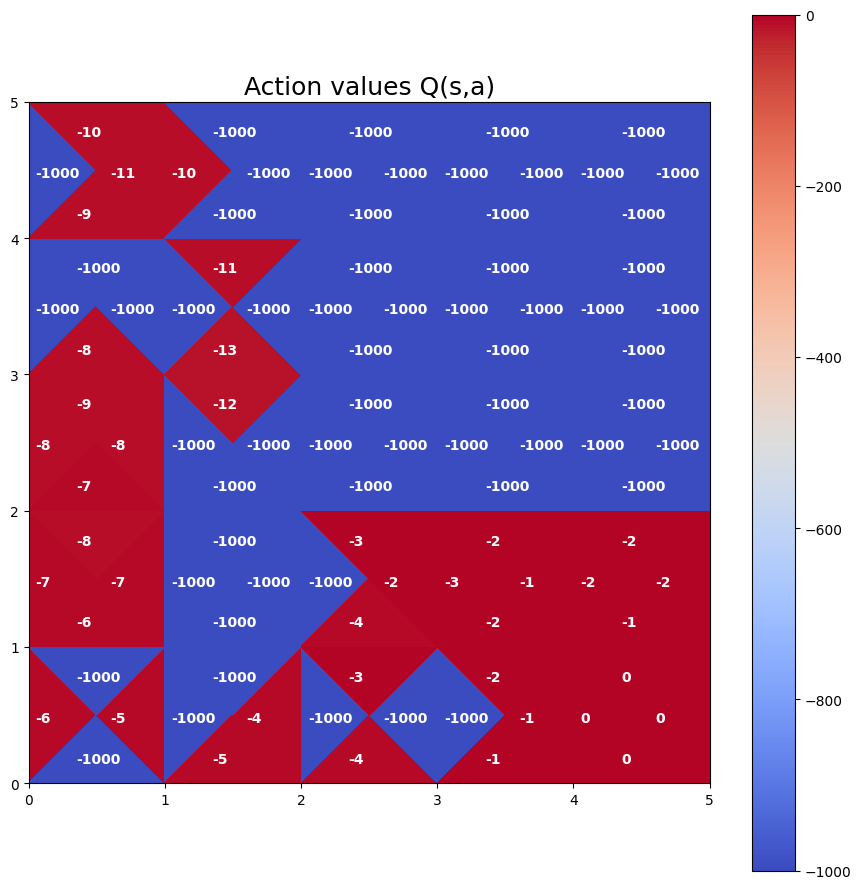

In [314]:
plot_action_values(action_values)

In [270]:
for x in reversed(t):
    print(x)
    print(" ")

[(4, 3), 1, -1.0]
 
[(3, 3), 2, -1.0]
 
[(3, 2), 1, -1.0]
 
[(4, 2), 0, -1.0]
 
[(4, 2), 2, -1.0]
 
[(4, 2), 1, -1.0]
 
[(4, 1), 1, -1.0]
 
[(4, 2), 3, -1.0]
 
[(4, 2), 1, -1.0]
 
[(4, 2), 1, -1.0]
 
[(4, 2), 2, -1.0]
 
[(4, 1), 1, -1.0]
 
[(4, 1), 2, -1.0]
 
[(4, 0), 1, -1.0]
 
[(4, 0), 2, -1.0]
 
[(3, 0), 2, -1.0]
 
[(3, 0), 1, -1.0]
 
[(3, 0), 3, -1.0]
 
[(3, 0), 3, -1.0]
 
[(2, 0), 2, -1.0]
 
[(2, 0), 1, -1.0]
 
[(2, 0), 3, -1.0]
 
[(2, 0), 1, -1.0]
 
[(2, 0), 3, -1.0]
 
[(3, 0), 0, -1.0]
 
[(2, 0), 2, -1.0]
 
[(3, 0), 0, -1.0]
 
[(4, 0), 0, -1.0]
 
[(3, 0), 2, -1.0]
 
[(3, 0), 1, -1.0]
 
[(4, 0), 0, -1.0]
 
[(3, 0), 2, -1.0]
 
[(3, 0), 3, -1.0]
 
[(2, 0), 2, -1.0]
 
[(1, 0), 2, -1.0]
 
[(2, 0), 0, -1.0]
 
[(2, 0), 3, -1.0]
 
[(2, 0), 1, -1.0]
 
[(3, 0), 0, -1.0]
 
[(3, 0), 3, -1.0]
 
[(2, 0), 2, -1.0]
 
[(1, 0), 2, -1.0]
 
[(2, 0), 0, -1.0]
 
[(3, 0), 0, -1.0]
 
[(4, 0), 0, -1.0]
 
[(4, 0), 2, -1.0]
 
[(3, 0), 2, -1.0]
 
[(4, 0), 0, -1.0]
 
[(4, 1), 3, -1.0]
 
[(4, 0), 1, -1.0]
 


In [252]:
env.reset()
print(f"The new episode will start in state: {initial_state}")

The new episode will start in state: (0, 0)


In [271]:
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

# Assuming t is a list of state-action pairs
for (state, action, reward) in t:
    # print(state, action)
    next_state, reward, done, info = env.step(action)
    frame = env.render(mode='rgb_array')
    
    # Display the image
    plt.axis('off')
    plt.title(f"State: {state}")
    plt.imshow(frame)
    display(plt.gcf())  # Display the current figure
    
    # Clear the previous output for the next iteration
    clear_output(wait=True)


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7fdb31313370> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 